<a href="https://colab.research.google.com/github/aghosh92/DCNN_MD/blob/main/DCNN_simulation_obj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows an example how to use the coordinates of atoms predicted by AtomAI, create a corresponding ASE object and perform MD simulations.


Install Atom AI

In [1]:
!pip install atomai

     |████████████████████████████████| 146 kB 6.7 MB/s 
     |████████████████████████████████| 503 kB 41.2 MB/s 
     |████████████████████████████████| 193 kB 49.3 MB/s 
     |████████████████████████████████| 865 kB 36.0 MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174982 sha256=a140ce0f4fd0a98cd5d4e896597c8b1d5073ccddc9c2b2ec3d8fe07fcc0a21e1
  Stored in directory: /root/.cache/pip/wheels/f4/4e/dd/06777c90710ce1766376ecc87979967fe69ff3affc29c0b530
Successfully built mendeleev


Install ASE

In [2]:
pip install ase

     |████████████████████████████████| 2.2 MB 8.4 MB/s 


Import essential libraries

In [3]:
import atomai as aoi
import numpy as np
import matplotlib.pyplot as plt
import os, re
import sys
import pandas as pd
import glob
import cv2 as cv
import glob
import imageio
from typing import Dict, List, Union

#ase
from ase import Atoms, Atom
import ase.io as io
from ase.io import read,write, vasp
from ase.io.trajectory import Trajectory
from ase.optimize import QuasiNewton
from ase.optimize.bfgslinesearch import BFGSLineSearch
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution, Stationary, ZeroRotation)
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.io.animation import write_mp4
from ase.calculators.lj import LennardJones
import ase.io as io
from ase.data.colors import jmol_colors
from ase.data import covalent_radii
from ase.geometry import wrap_positions

Mount google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Example 1:

This block shows two examples how to construct a supercell using coordinates predicted by a pre-trained Atom AI model, in case the coordinates of atoms are not readily available.

Load data into the notebook:

In [5]:
!gdown "https://drive.google.com/uc?id=1mpecY83LV0sqDbsCzvGgBw4XUhSkiTqZ"

Downloading...
From: https://drive.google.com/uc?id=1mpecY83LV0sqDbsCzvGgBw4XUhSkiTqZ
To: /content/Gdata_for_VAE0.npz
968MB [00:24, 40.3MB/s]


In [6]:
data = np.load("Gdata_for_VAE0.npz", allow_pickle=True)

#predict coordinates using a pre-trained Atom AI model

coordinates, dcnn_out, imgdata = data.values()
coordinates = coordinates[()]  # array to dict

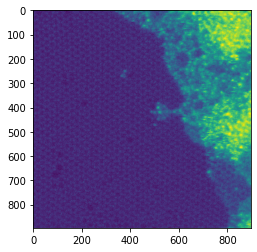

In [7]:
plt.imshow(imgdata[0,:,:])

In [8]:
coordinates_filtered = {}
for k, c in coordinates.items():
    coordinates_filtered[k] = c[c[:, -1] < 3]

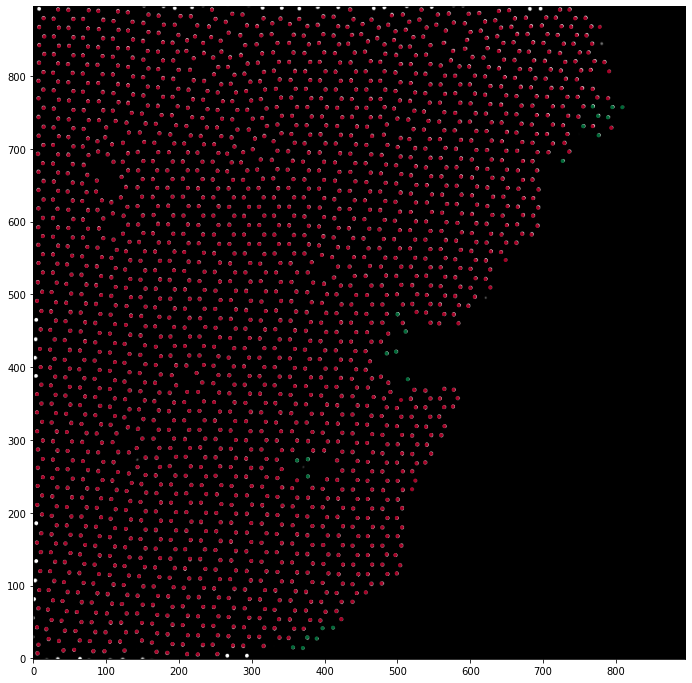

In [10]:
aoi.utils.plot_coord(dcnn_out[0,:,:,0], coordinates_filtered[0], fsize=12)

Save coordinates for specific frame (0) as ASE object

In [22]:
map_dict_graph = {0: "C", 1: "Si"}

In [24]:
aoi.utils.ase_obj_basic(coordinates, 0, "Graphene", map_dict_graph, "/content/drive/MyDrive/POSCAR_basic", 0.104)

You have successfully created an ASE object. 

This is a cubic cell of Graphene. 

Now you can read it in using ase.io.vasp.read_vasp. 



Read in the newly created object that is readable by ASE that can be used to perform molecular dynamics simulations.

In [25]:
atoms = io.vasp.read_vasp("/content/drive/MyDrive/POSCAR_basic")

In [ ]:
def printenergy(a):
# function to print the potential, kinetic and total energy
  epot = a.get_potential_energy() / len(a)
  ekin = a.get_kinetic_energy() / len(a)
  print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
                'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
  return epot, ekin

This is an example without the geometry optimization as implemented in ASE using Lennard-Jones pair potential.

In [ ]:
#setting the calculator
calc = LennardJones()
atoms.calc= calc


# do a quick geometry relaxation
#qn = QuasiNewton(atoms)
#qn.run(1e-4, 50) #convergence criteria

# set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)
Stationary(atoms) # zero linear momentum
ZeroRotation(atoms) # zero angular momentum

# run MD with constant energy using the VelocityVerlet algorithm
dyn = VelocityVerlet(atoms, 1 * units.fs, trajectory='/content/drive/MyDrive/trial.traj')

# now run the dynamics
epot_list_plot=[]
ekin_list_plot=[]
positions = []
printenergy(atoms)

for k in range(5): 
  loc_pos = []
  dyn.run(5) # number of steps

  printenergy(atoms)
  epot_temp, ekin_temp = printenergy(atoms)
  epot_list_plot.append(epot_temp)
  ekin_list_plot.append(ekin_temp)
  pos_atoms = atoms.get_positions(wrap=True) #for getting the positions of the atoms after the last timestep
  loc_pos.append(pos_atoms)
  positions.append(loc_pos)

Energy per atom: Epot = -0.854eV  Ekin = 0.039eV (T=301K)  Etot = -0.815eV
Energy per atom: Epot = -0.863eV  Ekin = 0.048eV (T=373K)  Etot = -0.815eV
Energy per atom: Epot = -0.863eV  Ekin = 0.048eV (T=373K)  Etot = -0.815eV
Energy per atom: Epot = -0.889eV  Ekin = 0.074eV (T=575K)  Etot = -0.815eV
Energy per atom: Epot = -0.889eV  Ekin = 0.074eV (T=575K)  Etot = -0.815eV
Energy per atom: Epot = -0.925eV  Ekin = 0.110eV (T=853K)  Etot = -0.815eV
Energy per atom: Epot = -0.925eV  Ekin = 0.110eV (T=853K)  Etot = -0.815eV
Energy per atom: Epot = -0.966eV  Ekin = 0.150eV (T=1163K)  Etot = -0.815eV
Energy per atom: Epot = -0.966eV  Ekin = 0.150eV (T=1163K)  Etot = -0.815eV
Energy per atom: Epot = -1.004eV  Ekin = 0.189eV (T=1459K)  Etot = -0.816eV
Energy per atom: Epot = -1.004eV  Ekin = 0.189eV (T=1459K)  Etot = -0.816eV


In [ ]:
traj = Trajectory('/content/drive/MyDrive/trial.traj')

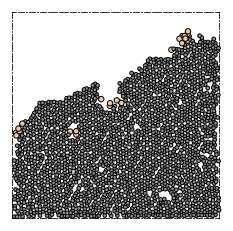

In [ ]:
write_mp4('/content/drive/MyDrive/trial.mp4',traj)

This is an example with the geometry optimization using the quasi-Newton approach as implemented in ASE using Lennard-Jone pair potential.
This isn't great to optimize the geometry without the system falling apart.

In [ ]:
#setting the calculator
calc = LennardJones()
atoms.calc= calc


# do a quick geometry relaxation
qn = QuasiNewton(atoms)
qn.run(1e-4, 50) #convergence criteria

# set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)
Stationary(atoms) # zero linear momentum
ZeroRotation(atoms) # zero angular momentum

# run MD with constant energy using the VelocityVerlet algorithm
dyn = VelocityVerlet(atoms, 1 * units.fs, trajectory='/content/drive/My Drive/Colab Notebooks/coords_exp_MD/trial_rel.traj')

# now run the dynamics
epot_list_plot=[]
ekin_list_plot=[]
positions = []
printenergy(atoms)

for k in range(5): 
  loc_pos = []
  dyn.run(5) # number of steps

  printenergy(atoms)
  epot_temp, ekin_temp = printenergy(atoms)
  epot_list_plot.append(epot_temp)
  ekin_list_plot.append(ekin_temp)
  pos_atoms = atoms.get_positions(wrap=True) #for getting the positions of the atoms after the last timestep
  loc_pos.append(pos_atoms)
  positions.append(loc_pos)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 03:04:54    -2051.747800*      17.1013
BFGSLineSearch:    1[  2] 03:04:54    -2124.818981*      20.9136
BFGSLineSearch:    2[  3] 03:05:09    -2155.156274*      89.9194
BFGSLineSearch:    3[  4] 03:05:24    -2169.891571*      33.8650
BFGSLineSearch:    4[  5] 03:05:40    -2196.564596*      17.4639
BFGSLineSearch:    5[  8] 03:05:57    -2244.045812*      12.3466
BFGSLineSearch:    6[ 10] 03:06:11    -2274.744642*      11.1274
BFGSLineSearch:    7[ 11] 03:06:25    -2311.955322*      44.0077
BFGSLineSearch:    8[ 13] 03:06:42    -2336.971240*      16.9341
BFGSLineSearch:    9[ 15] 03:06:56    -2368.736259*      19.1884
BFGSLineSearch:   10[ 17] 03:07:10    -2405.398741*      24.1028
BFGSLineSearch:   11[ 19] 03:07:27    -2443.747762*      37.4946
BFGSLineSearch:   12[ 21] 03:07:41    -2480.532463*      20.7320
BFGSLineSearch:   13[ 23] 03:07:55    -25

In [ ]:
traj = Trajectory('/content/drive/MyDrive/trial_rel.traj')

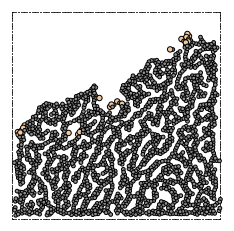

In [ ]:
write_mp4('/content/drive/MyDrive/trial_rel.mp4',traj)